In [1]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from yellowbrick.cluster import SilhouetteVisualizer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# k-means


In [2]:
blob_centers = np.array(
    [[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]]
)
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

k = 5
kmeans = KMeans(n_clusters=k, random_state=23)
y_pred = kmeans.fit_predict(X)


In [3]:
y_pred

array([1, 1, 4, ..., 3, 2, 1], dtype=int32)

In [4]:
y_pred is kmeans.labels_

True

In [5]:
kmeans.cluster_centers_

array([[-1.46893704,  2.28372774],
       [-2.80214068,  1.55162671],
       [ 0.18304455,  2.55635115],
       [-2.79290307,  2.79641063],
       [ 0.23444426,  1.90682419]])

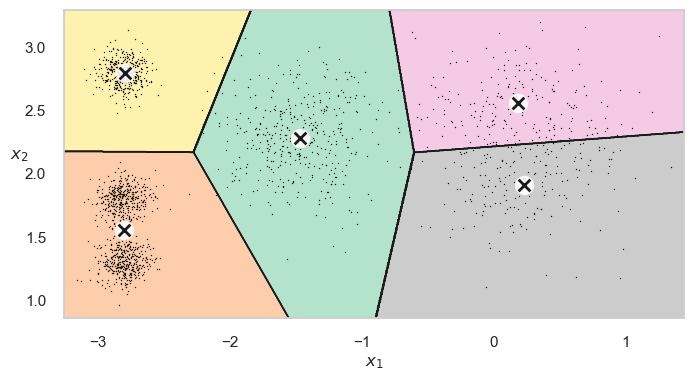

In [6]:
# extra code – this cell generates and saves Figure 9–3


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)


def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=35,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=2,
        linewidths=12,
        color=cross_color,
        zorder=11,
        alpha=1,
    )


def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)


plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()


## Soft clustering


In [7]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

## Hard clustering


Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful to give each instance a score per cluster, which is called soft clustering. The score can be the distance between the instance and the centroid or a similarity score (or affinity), such as the Gaussian radial basis function


In [8]:
kmeans.transform(X_new).round(2)

array([[1.5 , 2.84, 0.59, 2.9 , 0.25],
       [4.48, 5.82, 2.87, 5.85, 2.77],
       [1.69, 1.46, 3.21, 0.29, 3.41],
       [1.55, 0.97, 3.18, 0.36, 3.29]])

In [9]:
kmeans.inertia_

219.8438540223322

In [10]:
kmeans.score(X)

-219.8438540223322

## Mini-batch k-means


In [11]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=25)
minibatch_kmeans.fit(X)
minibatch_kmeans.score(X)


-220.53662747131594

## Optimizing the k-means algorithm


In [12]:
silhouette_score(X, kmeans.labels_)

0.6359484931112742

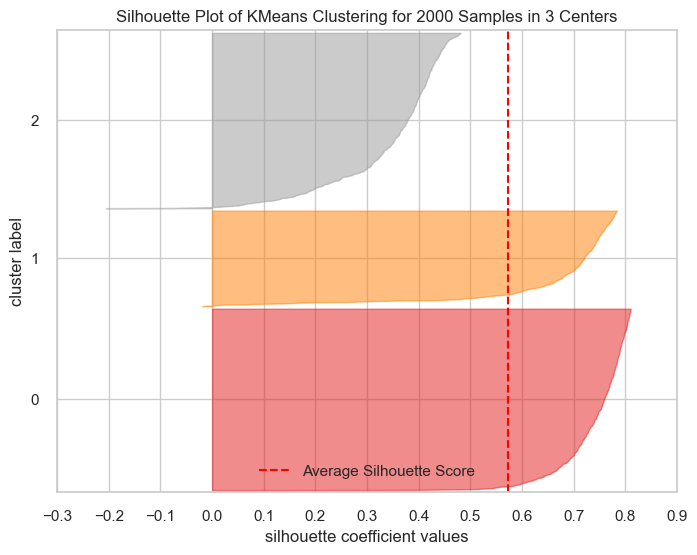

silhouette score: 0.57 for k=3


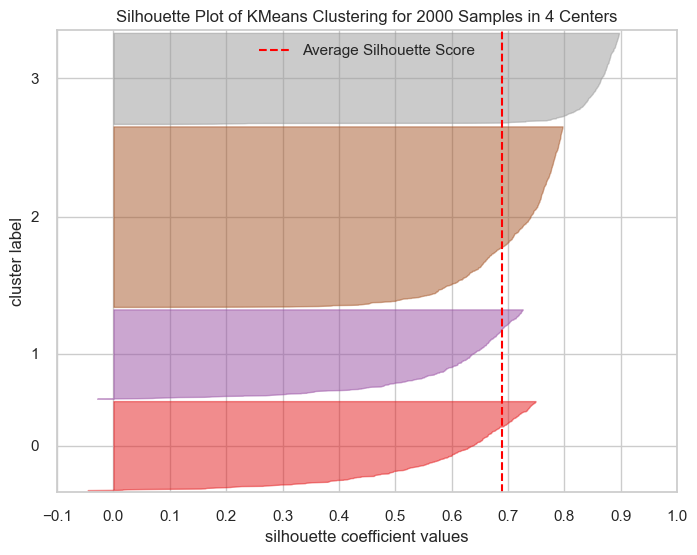

silhouette score: 0.69 for k=4


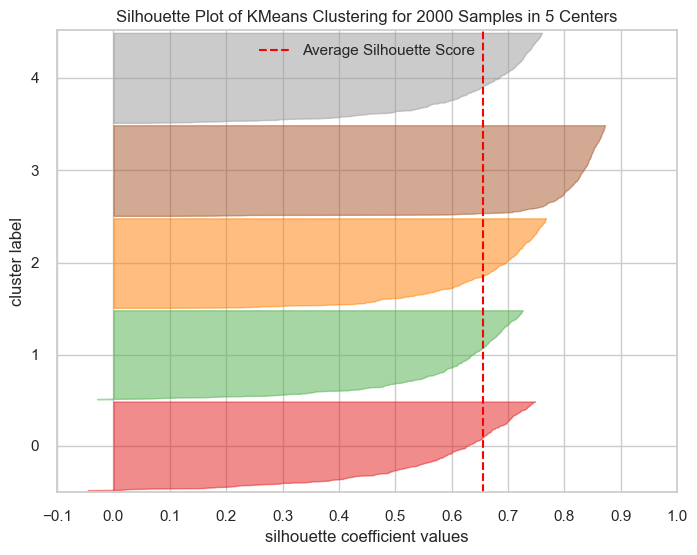

silhouette score: 0.66 for k=5


In [13]:
k_list = [3, 4, 5]
for k in k_list:
    visu = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=24, n_init=10))
    visu.fit(X)
    visu.show()
    print(f"silhouette score: {round(visu.silhouette_score_, 2)} for k={k}")


## Semi-Supervised Learning


In [14]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

log_reg.score(X_test, y_test)


0.7581863979848866

### Clustering data for representative images


First, let's cluster the training set into 50 clusters. Then, for each cluster, we'll find the image closest to the centroid. We'll call these images the representative images


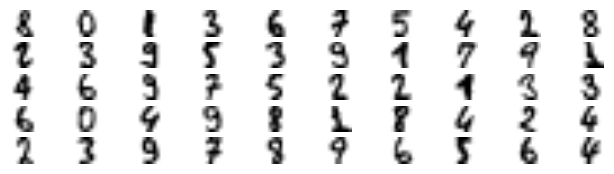

In [15]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(
        X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear"
    )
    plt.axis("off")
plt.show()


In [16]:
y_representative_digits = np.array(
    [
        1,
        3,
        6,
        0,
        7,
        9,
        2,
        4,
        8,
        9,
        5,
        4,
        7,
        1,
        2,
        6,
        1,
        2,
        5,
        1,
        4,
        1,
        3,
        3,
        8,
        8,
        2,
        5,
        6,
        9,
        1,
        4,
        0,
        6,
        8,
        3,
        4,
        6,
        7,
        2,
        4,
        1,
        0,
        7,
        5,
        1,
        9,
        9,
        3,
        7,
    ]
)


In [17]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)


0.16624685138539042

### Label propagation


In [18]:
y_trian_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_trian_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_trian_propagated)
log_reg.score(X_test, y_test)


0.11335012594458438

### Ignoring outliers


The following code first computes the distance from each instance to its closest cluster center, then for each cluster it sets the 1% largest distances to –1. Lastly, it creates a set without these instances marked with a –1 distance


In [19]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
    in_cluster = kmeans.labels_ == i
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = X_cluster_dist > cutoff_distance
    X_digits_dist[in_cluster & above_cutoff] = -1

partially_propagated = X_cluster_dist != -1
X_train_partially_propogated = X_train[partially_propagated]
y_train_partially_propogated = y_train[partially_propagated]

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_partially_propogated, y_train_partially_propogated)
log_reg.score(X_test, y_test)


0.9093198992443325

Scikit-Learn also offers two classes that can propagate labels automatically: LabelSpreading and LabelPropagation in the sklearn.semi_supervised package. Both classes construct a similarity matrix between all the instances, and iteratively propagate labels from labeled instances to similar unlabeled instances. There's also a very different class called SelfTrainingClassifier in the same package: you give it a base classifier (such as a RandomForestClassifier) and it trains it on the labeled instances, then uses it to predict labels for the unlabeled samples. It then updates the training set with the labels it is most confident about, and repeats this process of training and labeling until it
cannot add labels anymore. These techniques are not magic bullets, but they can occasionally give your model a little boost.


# DBSCAN


In [20]:
X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [21]:
dbscan.labels_[:10]

array([0, 0, 1, 1, 2, 2, 1, 1, 1, 2])

Notice that some instances have a cluster index equal to –1, which means that they are considered as anomalies by the algorithm


In [22]:
dbscan.core_sample_indices_[:10]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10])

In [23]:
dbscan.components_

array([[-0.69849959,  0.66510826],
       [-0.25678061,  0.93855402],
       [ 0.93505013, -0.54590905],
       ...,
       [ 0.0880413 ,  0.21983411],
       [-0.70215775,  0.64716355],
       [ 0.97918188,  0.04095748]])

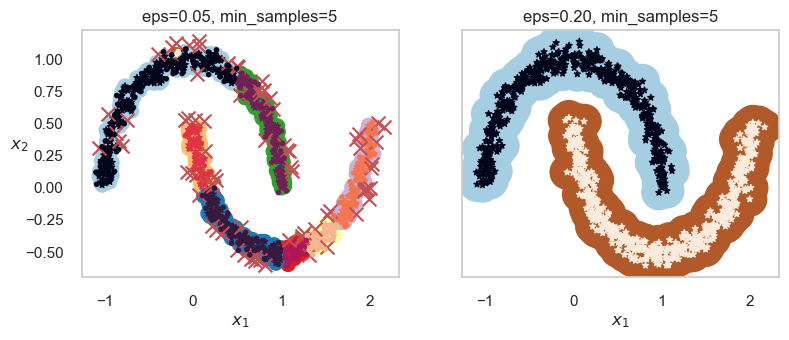

In [24]:
# extra code – this cell generates and saves Figure 9–14


def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(
        cores[:, 0],
        cores[:, 1],
        c=dbscan.labels_[core_mask],
        marker="o",
        s=size,
        cmap="Paired",
    )
    plt.scatter(cores[:, 0], cores[:, 1], marker="*", s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=100)
    plt.scatter(
        non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker="."
    )
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)


dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()


In [25]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)


array([0, 4, 2, 5])

In [26]:
knn.predict_proba(X_new)

array([[0.86, 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.18, 0.78, 0.04, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]])

In [27]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()[:10]


array([-1,  4,  2, -1])

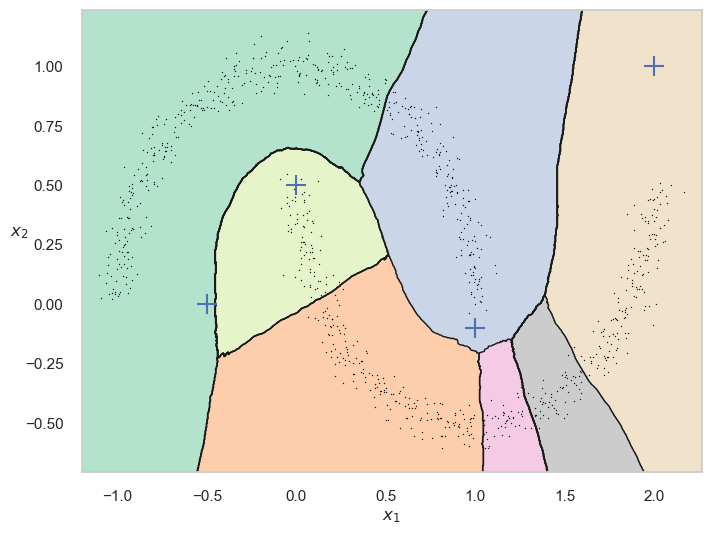

In [28]:
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()


# Gaussian mixtures


In [29]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

gm = GaussianMixture(n_components=3, n_init=20).fit(X)

In [30]:
gm.weights_


array([0.20954915, 0.40004337, 0.39040749])

In [31]:
gm.means_


array([[ 3.40011393,  1.05931676],
       [-1.40765148,  1.42718339],
       [ 0.0516183 ,  0.07550754]])

In [32]:
gm.covariances_


array([[[ 1.14631283, -0.03285453],
        [-0.03285453,  0.95505142]],

       [[ 0.63477114,  0.72969538],
        [ 0.72969538,  1.16085164]],

       [[ 0.68856426,  0.79633822],
        [ 0.79633822,  1.21252023]]])

This class relies on the expectation-maximization (EM) algorithm, which has many similarities with the k-means algorithm: it also initializes the cluster parameters randomly, then it repeats two steps until convergence, first assigning instances to clusters (this is called the expectation step) and then updating the clusters (this is called the maximization step). Sounds familiar, right? In the context of clustering, you can think of EM as a generalization of k-means that not only finds the cluster centers (μ(1) to μ(k)), but also their size, shape, and orientation (Σ(1) to Σ(k)), as well as their relative weights (φ(1) to φ(k)).


In [33]:
gm.converged_


True

In [34]:
gm.n_iter_


4

## Hard clustering with GMM


In [35]:
gm.predict(X)


array([2, 2, 1, ..., 0, 0, 0])

## Soft clustering with GMM


In [36]:
gm.predict_proba(X)


array([[2.30956994e-02, 6.73632768e-07, 9.76903627e-01],
       [1.63176388e-02, 6.72738827e-04, 9.83009622e-01],
       [1.96800317e-06, 9.99922105e-01, 7.59268139e-05],
       ...,
       [9.99999561e-01, 2.09167854e-26, 4.38851876e-07],
       [1.00000000e+00, 1.41536116e-41, 5.40181989e-16],
       [1.00000000e+00, 7.72772760e-41, 2.38611270e-15]])

## Generating new instances with GMM


In [37]:
X_new, y_new = gm.sample(10)

In [38]:
X_new


array([[ 2.65681679,  0.7978081 ],
       [ 3.25492776,  1.81921631],
       [ 5.19967853, -0.23648242],
       [ 4.37877546, -0.10794821],
       [ 3.72756868, -0.28095779],
       [ 6.14241468,  0.5306655 ],
       [-3.24150542, -0.56908715],
       [ 0.35012685,  0.29291262],
       [-0.76831934, -1.51767502],
       [-0.75770167, -0.28859965]])

In [39]:
y_new


array([0, 0, 0, 0, 0, 0, 1, 2, 2, 2])

## Density estimation


In [40]:
gm.score_samples(X).round(1)


array([-2.6, -3.6, -3.3, ..., -3.5, -4.4, -3.8])

<Figure size 800x600 with 0 Axes>

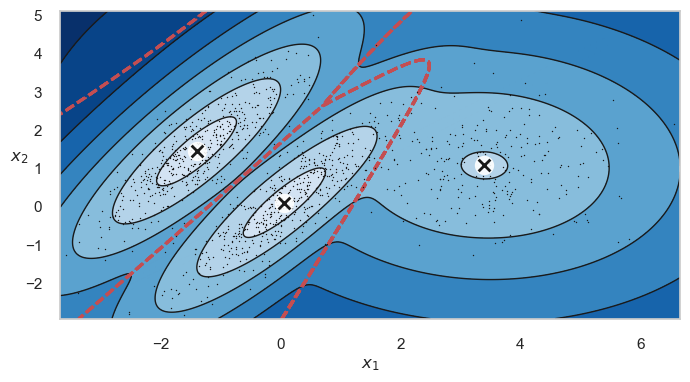

In [41]:
# extra code – this cells generates and saves Figure 9–16

from matplotlib.colors import LogNorm

plt.set_cmap("Blues")


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(
        xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12)
    )
    plt.contour(
        xx,
        yy,
        Z,
        norm=LogNorm(vmin=1.0, vmax=30.0),
        levels=np.logspace(0, 2, 12),
        linewidths=1,
        colors="k",
    )

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors="r", linestyles="dashed")

    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)


plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)


plt.show()

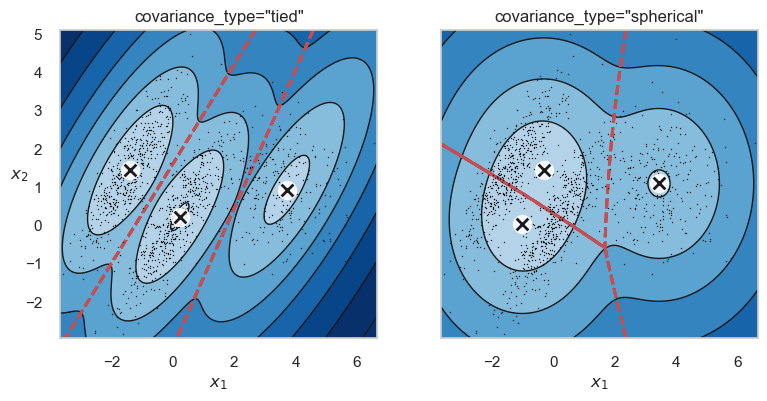

In [47]:
# extra code – this cell generates and saves Figure 9–17

gm_full = GaussianMixture(
    n_components=3, n_init=10, covariance_type="full", random_state=42
)
gm_tied = GaussianMixture(
    n_components=3, n_init=10, covariance_type="tied", random_state=42
)
gm_spherical = GaussianMixture(
    n_components=3, n_init=10, covariance_type="spherical", random_state=42
)
gm_diag = GaussianMixture(
    n_components=3, n_init=10, covariance_type="diag", random_state=42
)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)


def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title(f'covariance_type="{gm1.covariance_type}"')

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title(f'covariance_type="{gm2.covariance_type}"')


compare_gaussian_mixtures(gm_tied, gm_spherical, X)


plt.show()

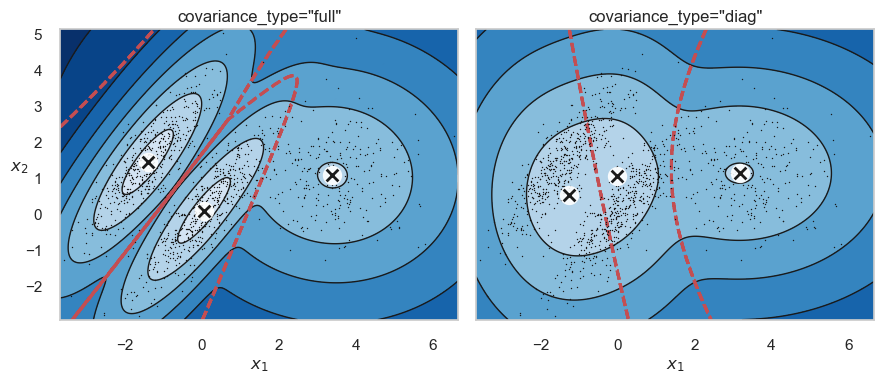

In [49]:
# extra code – comparing covariance_type="full" and covariance_type="diag"
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()


## Anomaly detection


Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly.


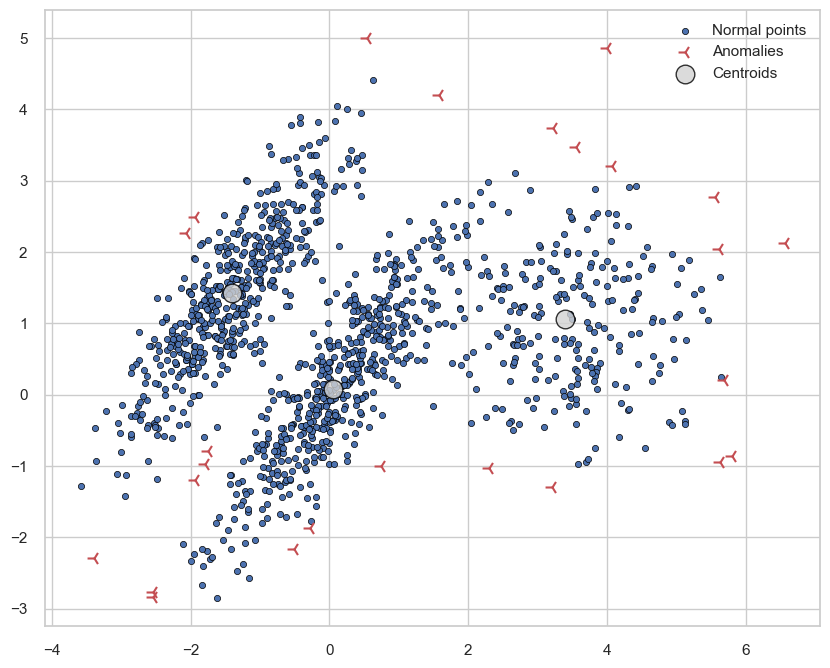

In [44]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]
nomalies = X[densities >= density_threshold]
centers = gm.means_

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    nomalies[:, 0],
    nomalies[:, 1],
    c="b",
    s=20,
    linewidths=0.5,
    edgecolor="black",
    label="Normal points",
)
ax.scatter(
    anomalies[:, 0], anomalies[:, 1], c="r", marker="3", s=100, label="Anomalies"
)
ax.scatter(
    centers[:, 0],
    centers[:, 1],
    c="lightgray",
    alpha=0.8,
    s=180,
    linewidths=1,
    edgecolors="black",
    label="Centroids",
)
ax.legend()

## Selecting the Number of Clusters


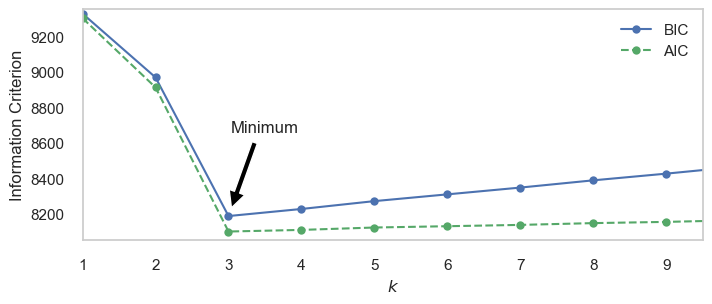

In [45]:
# extra code – this cell generates and saves Figure 9–20

gms_per_k = [
    GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
    for k in range(1, 11)
]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.annotate(
    "",
    xy=(3, bics[2]),
    xytext=(3.4, 8650),
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.text(3.5, 8660, "Minimum", horizontalalignment="center")
plt.legend()
plt.grid()

plt.show()


## Bayesian Gaussian Mixture Models


Set the number of clusters n_components to a value that you have good reason to believe is greater than the optimal number of clusters (this assumes some minimal knowledge about the problem at hand), and the algorithm will eliminate the unnecessary clusters automatically


In [46]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=65).fit(X)
bgm.weights_.round(2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])